# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys 
import numpy as np
import json
from scipy.stats import pearsonr
import seaborn
sys.path.insert(0, '../')
from src.helper import *
# controls = ['negative_control','positive_control']
# grn_models = ['collectri','granie', 'figr', 'celloracle', 'scglue', 'scenicplus']


results_folder = '../results_folder'
task_grn_inference_dir = '../../task_grn_inference'

%matplotlib inline

## Theta dist of reg 2

In [2]:
with open(os.path.join(task_grn_inference_dir, 'resources/prior', 'consensus-num-regulators.json'), 'r') as f:
    data = json.load(f)
gene_names_ = np.asarray(list(data.keys()), dtype=object)
n_features = {}
for theta in ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']:
    n_features[theta] = np.asarray([data[gene_name][theta] for gene_name in gene_names_], dtype=int)
n_features_dict = {gene_name: i for i, gene_name in enumerate(gene_names_)}

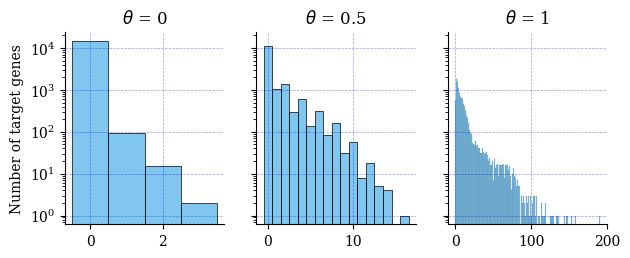

In [3]:
fig, axes = plt.subplots(1,3, figsize=(7, 2.5), sharey=True)

ax = axes[0]
seaborn.histplot(data=n_features['0'], ax=ax, discrete=True, color='#56B4E9', linewidth=.5)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
# ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 0')

ax = axes[1]
seaborn.histplot(data=n_features['0.5'], ax=ax, discrete=True, color='#56B4E9', linewidth=.5)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
# ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 0.5')

ax = axes[2]
seaborn.histplot(n_features['1'], ax=ax, discrete=True, color='#56B4E9')
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
# ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 1')

plt.savefig(f'{results_folder}/benchmark/figs/theta_reg2.png', dpi=300, transparent=True)
plt.show()

# Scores

In [4]:
scores_dir = '../../task_grn_inference/resources/results/scores'
!ls {scores_dir}

10000-skeleton_False-binarize_False_lognorm-ridge.csv
10000-skeleton_False-binarize_False_pearson-ridge.csv
10000-skeleton_False-binarize_True_lognorm-ridge.csv
10000-skeleton_False-binarize_True_pearson-ridge.csv
10000-skeleton_True-binarize_False_lognorm-ridge.csv
10000-skeleton_True-binarize_False_pearson-ridge.csv
10000-skeleton_True-binarize_True_lognorm-ridge.csv
10000-skeleton_True-binarize_True_pearson-ridge.csv
50000-skeleton_False-binarize_False_lognorm-ridge.csv
50000-skeleton_False-binarize_False_pearson-ridge.csv
50000-skeleton_False-binarize_True_lognorm-ridge.csv
50000-skeleton_False-binarize_True_pearson-ridge.csv
50000-skeleton_True-binarize_False_lognorm-ridge.csv
50000-skeleton_True-binarize_False_pearson-ridge.csv
50000-skeleton_True-binarize_True_lognorm-ridge.csv
50000-skeleton_True-binarize_True_pearson-ridge.csv


Text(0.5, 1.0, 'Default')

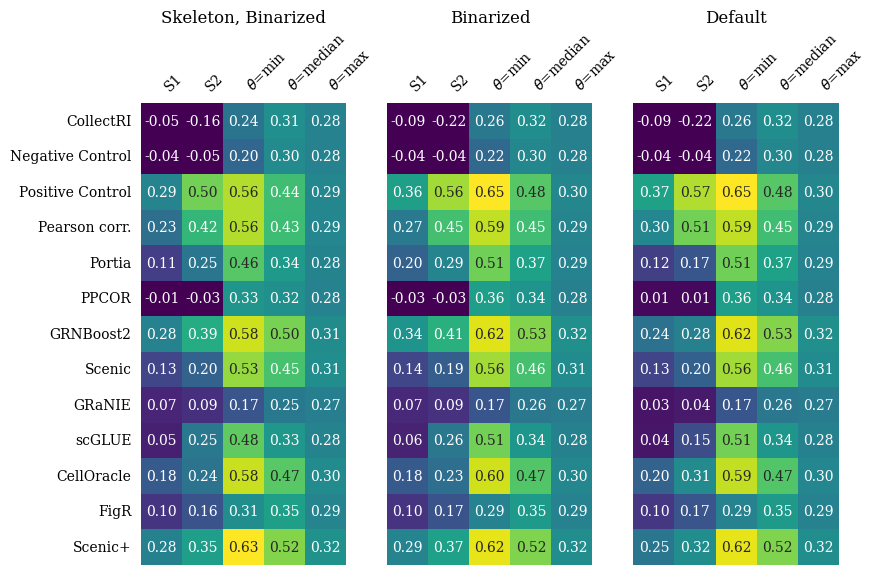

In [5]:
scores_mat_1 = pd.read_csv(f'{scores_dir}/50000-skeleton_True-binarize_True_pearson-ridge.csv', index_col=0)
scores_mat_1.columns = scores_mat_1.columns.map(surragate_names)
scores_mat_1.index = scores_mat_1.index.map(surragate_names)

scores_mat_2 = pd.read_csv(f'{scores_dir}/50000-skeleton_False-binarize_True_pearson-ridge.csv', index_col=0)
scores_mat_2.columns = scores_mat_2.columns.map(surragate_names)
scores_mat_2.index = scores_mat_2.index.map(surragate_names)

scores_mat_3 = pd.read_csv(f'{scores_dir}/50000-skeleton_False-binarize_False_pearson-ridge.csv', index_col=0)
scores_mat_3.columns = scores_mat_3.columns.map(surragate_names)
scores_mat_3.index = scores_mat_3.index.map(surragate_names)

fig, axes = plt.subplots(1, 3, figsize=(9, 6), sharey=True)

ax = axes[0]
plot_heatmap(scores_mat_1, name='', ax=ax, cmap="viridis")
ax.set_title('Skeleton, Binarized')
ax = axes[1]
plot_heatmap(scores_mat_2, name='', ax=ax, cmap="viridis")
ax.set_title('Binarized')
ax = axes[2]
plot_heatmap(scores_mat_3, name='', ax=ax, cmap="viridis")
ax.set_title('Default')
# scores_ridge
# fig.savefig(f"{results_folder}/benchmark/figs/benchmark_ridge_hvgs.png", dpi=300, transparent=True, bbox_inches='tight')

# Robustness analysis

In [6]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'S1'
    reg2_metric = 'static-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

In [7]:
base_dir = '../../task_grn_inference/resources/results/robustness_analysis'
figsize=(3.5, 3)

### TF-gene links

In [8]:
noise_type = 'net'
reg1_mat_net, reg2_mat_net = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'sign'
reg1_mat_sign, reg2_mat_sign = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'weight'
reg1_mat_weight, reg2_mat_weight = format_robustness_results(base_dir, noise_type=noise_type)


/vol/tmp/users/jnourisa/ipykernel_2607766/3925973280.py:29: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g = sns.catplot(
/vol/tmp/users/jnourisa/ipykernel_2607766/3925973280.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/vol/tmp/users/jnourisa/ipykernel_2607766/3925973280.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/vol/tmp/users/jnourisa/ipykernel_2607766/3925973280.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/vol/tmp/users/jnourisa/ipykernel_2607766/3925973280.py:29:

<Figure size 1000x600 with 0 Axes>

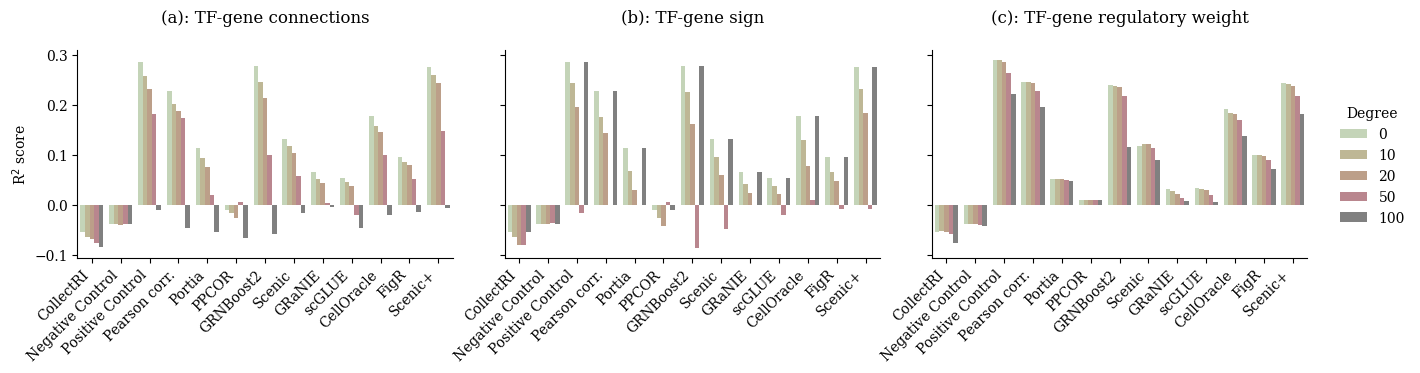

<Figure size 1000x600 with 0 Axes>

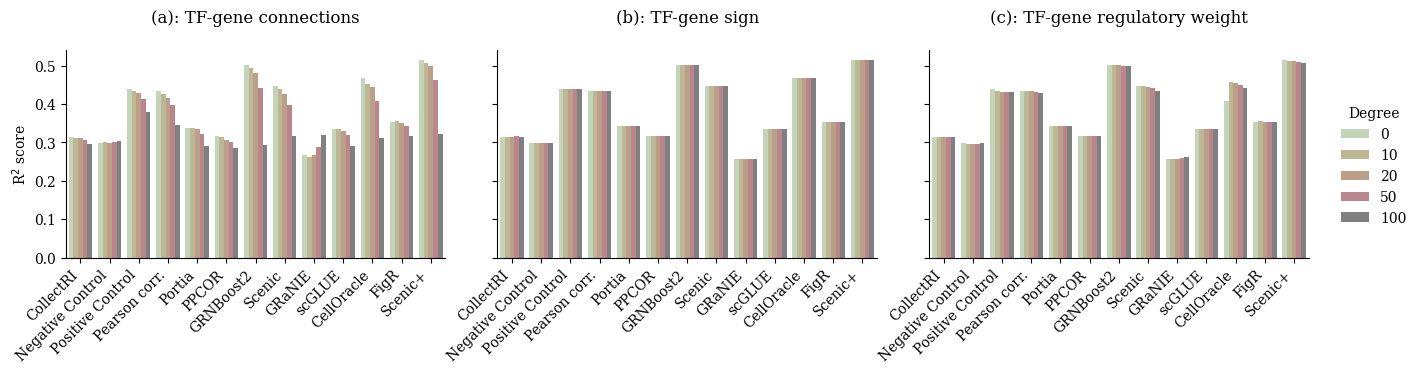

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_robustness(reg_mat_net, reg_mat_sign, reg_mat_weight):
    reg_mat_net['Permute type'] = 'TF-gene connections'
    reg_mat_sign['Permute type'] = 'TF-gene sign'
    reg_mat_weight['Permute type'] = 'TF-gene regulatory weight'


    # Concatenate the DataFrames
    df_concat = pd.concat([reg_mat_net, reg_mat_sign, reg_mat_weight])
    
    df_concat.columns = df_concat.columns.map(lambda name: surragate_names.get(name, name))
    # print(df_concat)

    # Reset the index so that noise degree remains a column
    df_concat.reset_index(inplace=True, drop=False)
    df_concat.rename(columns={'index': 'Degree'}, inplace=True)

    df_melt = pd.melt(df_concat, id_vars=['Degree', 'Permute type'], 
                    var_name='method', value_name=r'R$^2$ score')

    df_melt = df_melt[df_melt.method!='Degree']

    plt.figure(figsize=(10, 6))

    # Create a bar plot where noise types are nested within methods
    g = sns.catplot(
        data=df_melt, 
        x='method', 
        y=r'R$^2$ score', 
        hue='Degree', 
        col='Permute type', 
        kind='bar',
        height=3, 
        # width=6, 
        aspect=1.4,
        palette=colors_cell_type,
        legend_out=True
    )

    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Degree", bbox_to_anchor=(.95, 0.5), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        title = ax.get_title().replace('Permute type = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(title, pad=20)
    # plt.tight_layout()
    # plt.show()
plot_robustness(reg1_mat_net, reg1_mat_sign, reg1_mat_weight)
plot_robustness(reg2_mat_net, reg2_mat_sign, reg2_mat_weight)